# Propagation d'incertitude : Fiabilité (complément)

Ce *notebook* apporte des compléments concernant les méthodes FORM et tirages d'importance lorsqu'on est en présence de plusieurs points de défaillance le plus probable. Les solutions consistent à utiliser la méthode FORM système ou bien les tirages d'importance avec une densité instrumentale dirigée vers les 2 points $P^*$.

Les deux méthodes sont appliquées sur l'exemple de Der Kiureghian & Dakessian qui présente justement deux points $P^*$.

In [1]:
import openturns as ot
from openturns.viewer import View
import numpy as np
from matplotlib import pyplot as plt
%pylab --no-import-all inline
from mpl_toolkits.mplot3d import Axes3D
rcParams = { 'axes.grid': False,
             'axes.hold': True,
             'axes.labelsize': 16,
             'xtick.labelsize': 12,
             'ytick.labelsize': 12,
             'axes.linewidth': 0.5,
             'font.size': 16,
             'image.cmap': 'gray',
             'image.interpolation': 'bilinear',
             'legend.fontsize': 16,
             'legend.shadow': True,
             'lines.linewidth': 1.5,
             'text.latex.unicode': True}
plt.rcParams.update(rcParams)
light_gray = plt.matplotlib.colors.LinearSegmentedColormap.from_list(
                'light_gray', [[.9] * 3, [.6] * 3])
class FormatFaker(object):
    def __init__(self, str): self.str = str
    def __mod__(self, stuff): return self.str

Populating the interactive namespace from numpy and matplotlib


/gpfslocal/pub/python/anaconda/Anaconda2-4.3.1/lib/python2.7/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/gpfslocal/pub/python/anaconda/Anaconda2-4.3.1/lib/python2.7/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


## Der Kiureghian & Dakessian (1998)

Un exemple à deux "points de défaillance les plus probables" pour montrer les limites des approches basées sur l'hypothèse d'unicité d'un tel point (FORM, SORM, et MPFP-IS)

Dans cet exemple, la fonction d'état-limite est définie comme suit:

$g(x_1, x_2) = b - x_2 - \kappa\,(x_1 - e) ^ 2$,

et $\mathbf{X} \sim \mathcal{N}_2(\mathbf{0}, \mathbf{1})$.

Le paramètre d'excentricité $e > 0$ permet de favoriser l'influence un point de défaillance plutôt qu'un autre dans la probabilité, le coefficient $\kappa > 0$ contrôle la courbure de l'état-limite.

In [2]:
input_distribution = ot.Normal(2)

def g_(X):
    X = np.atleast_2d(X)
    b, kappa, e = 5., .5, .1
    return np.atleast_2d(b - X[:, 1] - kappa * (X[:, 0] - e) ** 2.).T
g = ot.PythonFunction(n=2, p=1, func_sample=g_)
g.setGradient(
    ot.NonCenteredFiniteDifferenceGradient(
        np.array(input_distribution.getStandardDeviation()) * 1e-2,
        g.getEvaluation()))
g.setHessian(
    ot.CenteredFiniteDifferenceHessian(
        np.array(input_distribution.getStandardDeviation()) * 1e-2,
        g.getEvaluation()))

G = ot.RandomVector(g, ot.RandomVector(input_distribution))

failure = ot.Event(G, ot.LessOrEqual(), 0.)

# 2. Transformation isoprobabiliste et représentations 2D du problème

In [3]:
def plot_in_standard_space(lim=6, res=50, ax=None, g0=0., approx=None):
    if ax is None:
        ax = plt.figure(figsize=(8, 8)).add_subplot(111)
    u1_plot, u2_plot = np.meshgrid(np.linspace(-lim, lim, res), np.linspace(-lim, lim, res))
    uu_plot = np.vstack([u1_plot.ravel(), u2_plot.ravel()]).T
    Tinv = input_distribution.getInverseIsoProbabilisticTransformation()
    gu_plot = np.reshape(g(Tinv(uu_plot)), (res, res))
    fu_plot = np.reshape(ot.Normal(2).computePDF(uu_plot), (res, res))
    im = ax.imshow(np.flipud(fu_plot), cmap=light_gray, extent=(-lim, lim, -lim, lim))
    cb = plt.colorbar(im)
    cb.set_label('$\\varphi(\mathbf{u})$')
    ax.contourf(u1_plot, u2_plot, gu_plot, [-np.inf, g0], colors='r', alpha=.2)
    c = ax.contour(u1_plot, u2_plot, gu_plot, [g0], colors='r', linestyles='solid', lw=2.)
    plt.clabel(c, fmt=FormatFaker('$g^{\circ}(\mathbf{u}) = %.2f$' % g0), colors='k')
    if approx is not None:
        for app in approx:
            approx_plot = np.reshape(app(uu_plot), (res, res))
            ax.contour(u1_plot, u2_plot, approx_plot, [g0], colors='b', linestyles='--', lw=2.)
            ax.contourf(u1_plot, u2_plot, approx_plot, [-np.inf, g0], colors='b', alpha=.2)
    ax.set_title('Standard space')
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_aspect(1.)
    ax.set_xlabel('$u_1$')
    ax.set_ylabel('$u_2$')
    origin = np.zeros(2)
    ax.plot(origin[0], origin[1], 'k.', markersize=15)
    plt.text(origin[0], origin[1], '$\mathbf{O}$', ha='left', va='bottom', fontdict={'fontsize': 14})
    plt.axvline(origin[0], color='k', linestyle='dashdot', linewidth=1.)
    plt.axhline(origin[1], color='k', linestyle='dashdot', linewidth=1.)
    return ax, locals()

In [4]:
def plot_in_physical_space(lim=6, res=50, ax=None, g0=0.):
    if ax is None:
        ax = plt.figure(figsize=(8, 8)).add_subplot(111)
    x1_lim = (input_distribution.getMarginal(0).computeQuantile(ot.Normal().computeCDF(-lim))[0],
              input_distribution.getMarginal(0).computeQuantile(1. - ot.Normal().computeCDF(-lim))[0])
    x2_lim = (input_distribution.getMarginal(1).computeQuantile(ot.Normal().computeCDF(-lim))[0],
              input_distribution.getMarginal(1).computeQuantile(1. - ot.Normal().computeCDF(-lim))[0])
    x1_plot, x2_plot = np.meshgrid(np.linspace(x1_lim[0], x1_lim[1], res),
                                   np.linspace(x2_lim[0], x2_lim[1], res))
    xx_plot = np.vstack([x1_plot.ravel(), x2_plot.ravel()]).T
    gx_plot = np.reshape(g(xx_plot), (res, res))
    fx_plot = np.reshape(input_distribution.computePDF(xx_plot), (res, res))
    im = ax.imshow(np.flipud(fx_plot), cmap=light_gray, extent=(x1_lim[0], x1_lim[1], x2_lim[0], x2_lim[1]))
    cb = plt.colorbar(im)
    cb.set_label('$f_{\mathbf{X}}(\mathbf{x})$')
    ax.contourf(x1_plot, x2_plot, gx_plot, [-np.inf, g0], colors='r', alpha=.2)
    c = ax.contour(x1_plot, x2_plot, gx_plot, [g0], colors='r', linestyles='solid', lw=2.)
    plt.clabel(c, fmt=FormatFaker('$g(\mathbf{x}) = %.2f$' % g0), colors='k')
    ax.set_title('Physical space')
    ax.set_xlim(*x1_lim)
    ax.set_ylim(*x2_lim)
    #ax.set_aspect(np.diff(x1_lim) / np.diff(x2_lim))
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    median = input_distribution.computeQuantile(.5)
    ax.plot(median[0], median[1], 'k.', markersize=15)
    plt.text(median[0], median[1], '$\mathbf{X}_{50\%}$', ha='left', va='bottom', fontdict={'fontsize': 14})
    plt.axvline(median[0], color='k', linestyle='dashdot', linewidth=1.)
    plt.axhline(median[1], color='k', linestyle='dashdot', linewidth=1.)
    return ax, locals()

/gpfslocal/pub/python/anaconda/Anaconda2-4.3.1/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


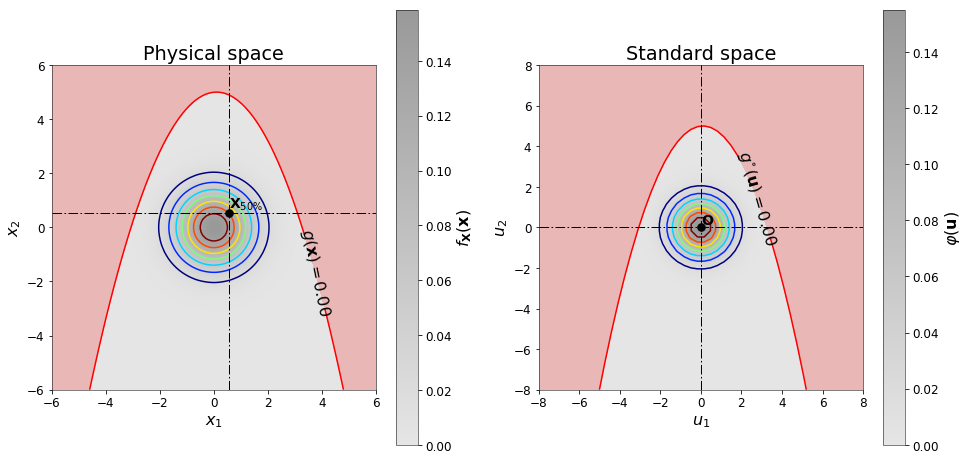

In [5]:
fig = plt.figure(figsize=(16, 8))
ax, data_plot = plot_in_physical_space(res=100, ax=fig.add_subplot(121))
ax.contour(data_plot['x1_plot'], data_plot['x2_plot'], data_plot['fx_plot'], cmap=plt.matplotlib.cm.jet)
ax, data_plot_st = plot_in_standard_space(ax=fig.add_subplot(122), lim=8.)
ax.contour(data_plot_st['u1_plot'], data_plot_st['u2_plot'], data_plot_st['fu_plot'], cmap=plt.matplotlib.cm.jet)
fig.show()

** Surface dans l'espace physique**

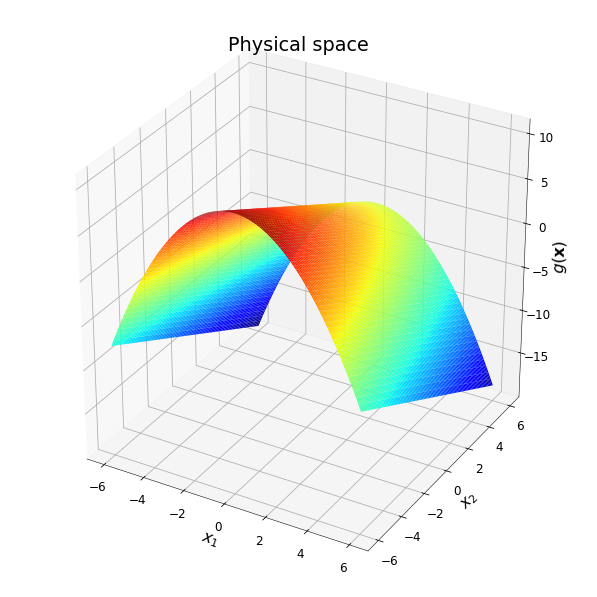

In [6]:
fig = plt.figure(figsize=(8, 8))
ax = Axes3D(fig)
ax.plot_surface(data_plot['x1_plot'], data_plot['x2_plot'], data_plot['gx_plot'],
                cmap=plt.matplotlib.cm.jet, rstride=1, cstride=1, lw=0.)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$g(\mathbf{x})$')
ax.set_title('Physical space')
fig.show()

** Surface dans l'espace standard **

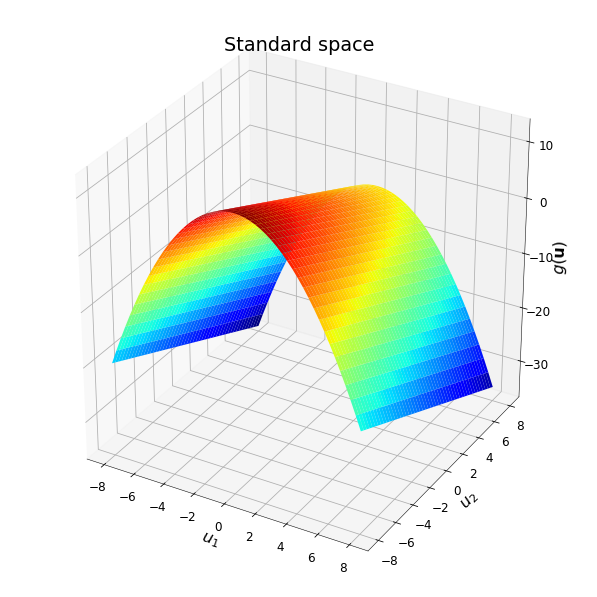

In [7]:
fig = plt.figure(figsize=(8, 8))
ax = Axes3D(fig)
ax.plot_surface(data_plot_st['u1_plot'], data_plot_st['u2_plot'], data_plot_st['gu_plot'],
                cmap=plt.matplotlib.cm.jet, rstride=1, cstride=1, lw=0.)
ax.set_xlabel('$u_1$')
ax.set_ylabel('$u_2$')
ax.set_zlabel('$g(\mathbf{u})$')
ax.set_title('Standard space')
fig.show()

# 3. Estimation par simple simulation de Monte Carlo

In [8]:
# Activation de l'historique
g.enableHistory()
g.clearHistory()

In [9]:
# Création de l'objet MonteCarlo
MCS_algorithm = ot.MonteCarlo(failure)

# Fixe le coefficient de variation maximum à 30%
MCS_algorithm.setMaximumCoefficientOfVariation(.05)

# Fixe le nombre de tirage à MaximumOuterSampling x BlockSize
MCS_algorithm.setMaximumOuterSampling(int(1e4))
# Blocksize permet d'envoyer par paquet les points à évaluer
MCS_algorithm.setBlockSize(int(1e2)) 

# Lancement de la simulation
MCS_algorithm.run()
MCS_results = MCS_algorithm.getResult()

# Récupération du nombre d'évaluations
MCS_evaluation_number = g.getHistoryInput().getSample().getSize()

In [10]:
print('Probability estimate: %.3e' % MCS_results.getProbabilityEstimate())
print('Coefficient of variation: %.2f' % MCS_results.getCoefficientOfVariation())
print('Number of evaluations: %d' % MCS_evaluation_number)

Probability estimate: 3.010e-03
Coefficient of variation: 0.05
Number of evaluations: 133900


**Affichage des tirages dans les espaces physique et standard**

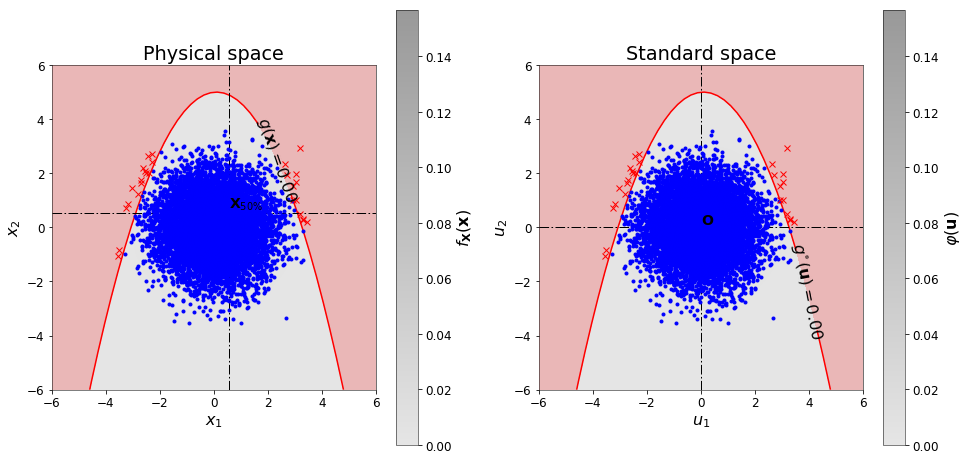

In [11]:
fig = plt.figure(figsize=(16, 8))

# Récupération des tirages et la valeur de g en ces points
input_sample = np.array(g.getHistoryInput().getSample())[:int(1e4)]
output_sample = np.ravel(g.getHistoryOutput().getSample())[:int(1e4)]

# Plot espace physique
ax, data_plot = plot_in_physical_space(ax=fig.add_subplot(121))
ax.plot(input_sample[output_sample > 0., 0], input_sample[output_sample > 0., 1], 'b.')
ax.plot(input_sample[output_sample <= 0., 0], input_sample[output_sample <= 0., 1], 'rx')

# plot espace standard
ax, data_plot = plot_in_standard_space(ax=fig.add_subplot(122))
# Attention, il faut utiliser la méthode getIsoProbabilisticTransformation pour transformer
# les variables d'entrée dans l'espace standard
input_sample = np.array(input_distribution.getIsoProbabilisticTransformation()(input_sample))
ax.plot(input_sample[output_sample > 0., 0], input_sample[output_sample > 0., 1], 'b.')
ax.plot(input_sample[output_sample <= 0., 0], input_sample[output_sample <= 0., 1], 'rx')
fig.show()

# 4. Approches basées sur le point de défaillance le plus probable

Dans le but d'appliquer la méthode FORM système, il existe un algorithme, appelé multi FORM, qui permet de trouver plusieurs points $P^*$. Pour cet exemple, l'algorithme classique est utilisé en faisant varier uniquement le point de départ.

In [12]:
g.enableHistory()
g.clearHistory()

In [13]:
# Spécification de la fonction contrainte, dans l'espace standard !!!
Tinv = input_distribution.getInverseIsoProbabilisticTransformation()

# Définition du problème d'optimisation
gt = ot.NumericalMathFunction(g, Tinv)
optimProblem = ot.OptimizationProblem(gt, 0.)

# Algorithme AbdoRackwitz
design_point_algorithm = ot.AbdoRackwitz(optimProblem)

# Point de départ multiples fixé manuellement
design_point_in_physical_space = list()
design_point_in_standard_space = list()
start_points = [[0., 0.], [1, 1]]
for point in start_points:
    design_point_algorithm.setStartingPoint(point)
    design_point_algorithm.run()
    search_results = design_point_algorithm.getResult()
    design_point_in_standard_space.append(search_results.getOptimalPoint())
    design_point_in_physical_space.append(Tinv(design_point_in_standard_space[-1]))
design_point_in_physical_space = np.array(design_point_in_physical_space)
design_point_in_standard_space = np.array(design_point_in_physical_space)

In [14]:
design_point_in_standard_space

array([[-2.74021692,  0.96658532],
       [ 2.9164392 ,  1.03383299]])

In [15]:
gapprox = []
ustar0 = design_point_in_standard_space[0]
def g0py0(u):
    g0 = g.gradient(Tinv(ustar0)).transpose() * (u - ustar0)
    return g0
gapprox.append(ot.PythonFunction(2, 1, g0py0))
ustar1 = design_point_in_standard_space[1]
def g0py1(u):
    g0 = g.gradient(Tinv(ustar1)).transpose() * (u - ustar1)
    return g0
gapprox.append(ot.PythonFunction(2, 1, g0py1))

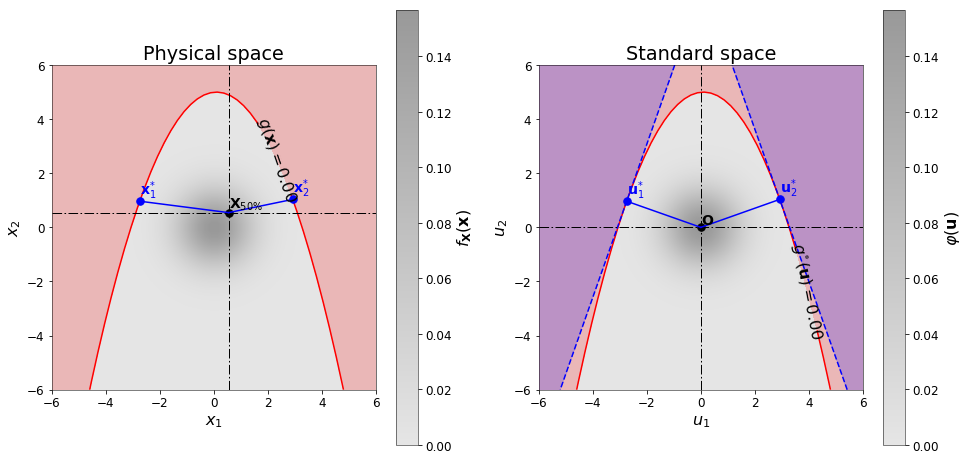

In [16]:
fig = plt.figure(figsize=(16, 8))
# plot espace physique
ax, data_plot = plot_in_physical_space(ax=fig.add_subplot(121))
ax.plot([input_distribution.computeQuantile(.5)[0], design_point_in_physical_space[0, 0]],
        [input_distribution.computeQuantile(.5)[1], design_point_in_physical_space[0, 1]], 'b-')
ax.plot([input_distribution.computeQuantile(.5)[0], design_point_in_physical_space[1, 0]],
        [input_distribution.computeQuantile(.5)[1], design_point_in_physical_space[1, 1]], 'b-')
ax.plot(design_point_in_physical_space[:, 0], design_point_in_physical_space[:, 1],
        'b.', markersize=15)
plt.text(design_point_in_physical_space[0, 0], design_point_in_physical_space[0, 1],
        '$\mathbf{x}_1^{*}$', ha='left', va='bottom', color='b', fontdict={'fontsize': 14})
plt.text(design_point_in_physical_space[1, 0], design_point_in_physical_space[1, 1],
        '$\mathbf{x}_2^{*}$', ha='left', va='bottom', color='b', fontdict={'fontsize': 14})
# plot espace standard
ax, data_plot = plot_in_standard_space(ax=fig.add_subplot(122), approx=gapprox)
ax.plot([0., design_point_in_standard_space[0, 0]],
        [0., design_point_in_standard_space[0, 1]], 'b-')
ax.plot([0., design_point_in_standard_space[1, 0]],
        [0., design_point_in_standard_space[1, 1]], 'b-')
ax.plot(np.array(design_point_in_standard_space)[:, 0], 
        np.array(design_point_in_standard_space)[:, 1],
        'b.', markersize=15)
plt.text(design_point_in_standard_space[0, 0], design_point_in_standard_space[0, 1],
        '$\mathbf{u}_1^{*}$', ha='left', va='bottom', color='b', fontdict={'fontsize': 14})
plt.text(design_point_in_standard_space[1, 0], design_point_in_standard_space[1, 1],
        '$\mathbf{u}_2^{*}$', ha='left', va='bottom', color='b', fontdict={'fontsize': 14})
fig.show()

## 4.1. First order reliability method system

Il est possible de prendre en compte plusieurs points $P^*$ et de calculer une probabilité système prendant en compte plusieurs état-limites linéaires (approximés). La probabilité se calcule comme suit dans le cas d'un système série (union des domaines) :

\begin{equation}
    p_{f, FORM SYS} = 1 - \Phi_n (\boldsymbol \beta_{HL}; \boldsymbol \rho)
\end{equation}

où $\boldsymbol \beta_{HL}$ est l'ensemble des indices de fiabilité associés à chaque point $P^*$ considéré, et $\boldsymbol \rho$ représente la corrélation entre les état-limites : $ \rho_{ij} = \boldsymbol \alpha^{(i)t} \boldsymbol \alpha^{(j)}$.

In [17]:
# Calcul du vecteur beta à partir des coordonnées u*
Beta = np.sqrt(np.sum(design_point_in_standard_space**2, axis=1))

# Calcul des vecteurs alpha associés à chaque P*
alpha = [design_point_in_standard_space[i] / Beta[i] for i in range(2)]

# calcul de la matrice de corrélation rho
rho = ot.CorrelationMatrix(2)
rho[1,0] = np.dot(alpha[0], alpha[1])

# Calcul de la probabilité de défaillance à partir de la multinormale en dimension 2
# avec la corrélation rho
multiNor = ot.Normal(ot.NumericalPoint([0,0]),ot.NumericalPoint([1,1]),
                     ot.CorrelationMatrix(rho))
Pfsys = 1 - multiNor.computeCDF(Beta)

print 'Hasofer-Lind reliability index: ', Beta
print 'First-order approximation of the probability: %.3e' % Pfsys

Hasofer-Lind reliability index:  [ 2.90569715  3.09425731]
First-order approximation of the probability: 2.819e-03


## 4.2. Echantillonnage préférentiel au point de défaillance le plus probable (Tirages d'importance, MPFP-IS)

In [18]:
g.enableHistory()
g.clearHistory()

In [19]:
# Création de la densité instrumentale : mixture de 2 lois normales centrées chacune sur un des points P*
corr = ot.IdentityMatrix(2)
DistributionTirage1 = ot.Normal(design_point_in_standard_space[0], corr)
DistributionTirage2 = ot.Normal(design_point_in_standard_space[1], corr)
instrumental_distribution = ot.Mixture([DistributionTirage1, DistributionTirage2])

# Création de l'objet ImportanceSampling avec :
#  - l'événement dans l'espace standard (--> fonction de performance définie dans l'espace standard)
#  - la densité instrumentale
IS_algorithm = ot.ImportanceSampling(ot.StandardEvent(failure), instrumental_distribution)
IS_algorithm.setMaximumCoefficientOfVariation(.05)
IS_algorithm.setMaximumOuterSampling(int(1e3))
IS_algorithm.setBlockSize(int(1e1))
IS_algorithm.run()
IS_results = IS_algorithm.getResult()
IS_evaluation_number = g.getHistoryInput().getSample().getSize()

In [20]:
print('Probability estimate: %.3e' % IS_results.getProbabilityEstimate())
print('Coefficient of variation: %.2f' % IS_results.getCoefficientOfVariation())
print('Number of evaluations: %d' % IS_evaluation_number)

Probability estimate: 2.898e-03
Coefficient of variation: 0.05
Number of evaluations: 1550


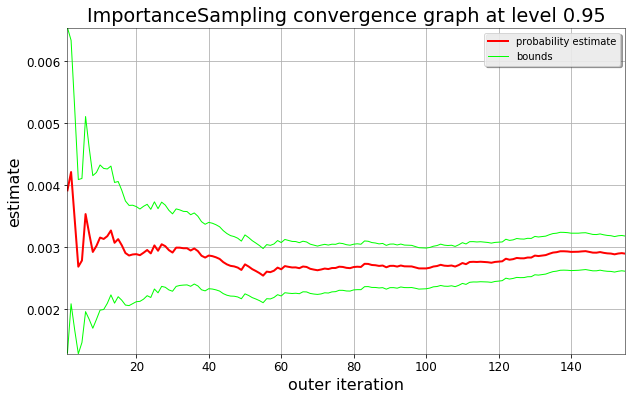

In [21]:
View(IS_algorithm.drawProbabilityConvergence(), figure_kwargs={'figsize':(10,6)}).show()

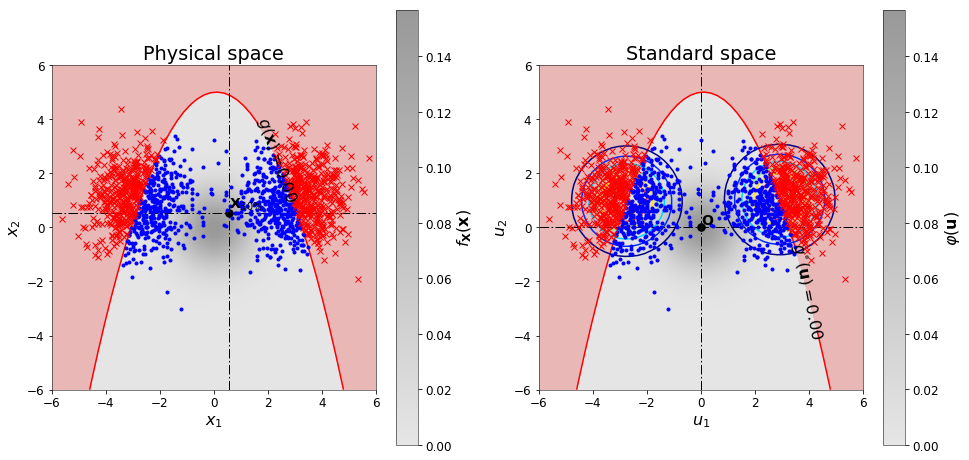

In [22]:
fig = plt.figure(figsize=(16, 8))
input_sample = np.array(g.getHistoryInput().getSample())
output_sample = np.ravel(g.getHistoryOutput().getSample())
ax, data_plot = plot_in_physical_space(ax=fig.add_subplot(121))
ax.plot(input_sample[output_sample > 0., 0], input_sample[output_sample > 0., 1], 'b.')
ax.plot(input_sample[output_sample <= 0., 0], input_sample[output_sample <= 0., 1], 'rx')
ax, data_plot = plot_in_standard_space(ax=fig.add_subplot(122))
input_sample = np.array(input_distribution.getIsoProbabilisticTransformation()(input_sample))
ax.contour(data_plot['u1_plot'], data_plot['u2_plot'],
           np.reshape(instrumental_distribution.computePDF(data_plot['uu_plot']),
                      data_plot['u1_plot'].shape),
           cmap=plt.matplotlib.cm.jet)
ax.plot(input_sample[output_sample > 0., 0], input_sample[output_sample > 0., 1], 'b.')
ax.plot(input_sample[output_sample <= 0., 0], input_sample[output_sample <= 0., 1], 'rx')
fig.show()